In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-06 15:05:22.698111: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-06 15:05:22.698191: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
df= pd.read_csv('colheitas.csv', parse_dates=['date'])
df['nr'].fillna(value=0, inplace=True)
df=df.groupby('date').sum()
df=df.resample(rule='M').sum()
df = df.iloc[:-1 , :]

### Create batches of training data (12 months)

In [4]:
def split_sequence(sequence, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [5]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(Dense(800, activation='relu', input_shape=(n_steps_in,)))
    model.add(Dense(800, activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3),
                bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=500, verbose=1, callbacks=[callback])
    return model 

In [6]:
def train_predict(dataset, test, actual):
    n_steps_in, n_steps_out, slide = 6, 2, 1
    X, y = split_sequence(train['nr'].values.tolist(), n_steps_in, n_steps_out, slide)
    
    model = fit(X, y, n_steps_in, n_steps_out)
        
    mae, rmse, smape = list(), list(), list()
    for i in range(0, len(test)-n_steps_in, n_steps_out):
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_steps_in)) 
        pred = model.predict(x_input) 
        mae_aux, rmse_aux, smape_aux = measure_error(test, pred, n_steps_in, n_steps_out, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
    
    return mae, rmse, smape

In [7]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [8]:
def measure_error(actual, pred, step_in, step_out, index):
    #print(actual[index+step_in:index+step_in+step_out],pred,index+step_in,index+step_in+step_out)
    mae = mean_absolute_error(array([actual['nr'][index+step_in:index+step_in+step_out]]), pred)
    rmse = np.sqrt(mean_squared_error(array([actual['nr'][index+step_in:index+step_in+step_out]]), pred))
    smape = sMAPE(array([actual['nr'][index+step_in:index+step_in+step_out]]), pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [9]:
len(df)

251

In [10]:
train=df[:215]
test=df[215:]
mae, rmse, smape = train_predict(train, test, test.values)

2022-10-06 15:05:25.095781: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-06 15:05:25.095829: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-06 15:05:25.095863: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-06 15:05:25.096232: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
7/7 [==============================] - 1s 21ms/step - loss: 120002864.0000
Epoch 2/500
7/7 [==============================] - 0s 25ms/step - loss: 19596910.0000
Epoch 3/500
7/7 [==============================] - 0s 22ms/step - loss: 15547194.0000
Epoch 4/500
7/7 [==============================] - 0s 26ms/step - loss: 8302330.5000
Epoch 5/500
7/7 [==============================] - 0s 22ms/step - loss: 5389260.5000
Epoch 6/500
7/7 [==============================] - 0s 24ms/step - loss: 4862259.0000
Epoch 7/500
7/7 [==============================] - 0s 23ms/step - loss: 4782248.0000
Epoch 8/500
7/7 [==============================] - 0s 22ms/step - loss: 4707021.5000
Epoch 9/500
7/7 [==============================] - 0s 28ms/step - loss: 4423709.5000
Epoch 10/500
7/7 [==============================] - 0s 21ms/step - loss: 4749315.0000
Epoch 11/500
7/7 [==============================] - 0s 21ms/step - loss: 4287754.0000
Epoch 12/500
7/7 [==============================] - 0s 22ms

7/7 [==============================] - 0s 25ms/step - loss: 3787195.7500
Epoch 97/500
7/7 [==============================] - 0s 21ms/step - loss: 3408013.2500
Epoch 98/500
7/7 [==============================] - 0s 22ms/step - loss: 3657631.5000
Epoch 99/500
7/7 [==============================] - 0s 25ms/step - loss: 3319731.0000
Epoch 100/500
7/7 [==============================] - 0s 24ms/step - loss: 3169997.0000
Epoch 101/500
7/7 [==============================] - 0s 23ms/step - loss: 3269628.2500
Epoch 102/500
7/7 [==============================] - 0s 24ms/step - loss: 3192819.7500
Epoch 103/500
7/7 [==============================] - 0s 26ms/step - loss: 3151534.5000
Epoch 104/500
7/7 [==============================] - 0s 23ms/step - loss: 4065096.2500
Epoch 105/500
7/7 [==============================] - 0s 21ms/step - loss: 3680393.2500
Epoch 106/500
7/7 [==============================] - 0s 24ms/step - loss: 3420569.7500
Epoch 107/500
7/7 [==============================] - 0s 24ms

7/7 [==============================] - 0s 32ms/step - loss: 3031566.2500
Epoch 191/500
7/7 [==============================] - 0s 23ms/step - loss: 3139603.5000
Epoch 192/500
7/7 [==============================] - 0s 28ms/step - loss: 3374851.5000
Epoch 193/500
7/7 [==============================] - 0s 33ms/step - loss: 3236337.7500
Epoch 194/500
7/7 [==============================] - 0s 24ms/step - loss: 3142517.0000
Epoch 195/500
7/7 [==============================] - 0s 29ms/step - loss: 3043077.0000
Epoch 196/500
7/7 [==============================] - 0s 26ms/step - loss: 3606737.7500
Epoch 197/500
7/7 [==============================] - 0s 26ms/step - loss: 3985005.5000
Epoch 198/500
7/7 [==============================] - 0s 26ms/step - loss: 3384806.7500
Epoch 199/500
7/7 [==============================] - 0s 25ms/step - loss: 3090305.0000
Epoch 200/500
7/7 [==============================] - 0s 32ms/step - loss: 3055420.5000
Epoch 201/500
7/7 [==============================] - 0s 2

7/7 [==============================] - 0s 28ms/step - loss: 2881791.0000
Epoch 285/500
7/7 [==============================] - 0s 22ms/step - loss: 2648029.0000
Epoch 286/500
7/7 [==============================] - 0s 22ms/step - loss: 2688185.7500
Epoch 287/500
7/7 [==============================] - 0s 22ms/step - loss: 2662652.5000
Epoch 288/500
7/7 [==============================] - 0s 25ms/step - loss: 2630486.7500
Epoch 289/500
7/7 [==============================] - 0s 28ms/step - loss: 2742658.5000
Epoch 290/500
7/7 [==============================] - 0s 23ms/step - loss: 2614380.5000
Epoch 291/500
7/7 [==============================] - 0s 23ms/step - loss: 2620837.2500
Epoch 292/500
7/7 [==============================] - 0s 22ms/step - loss: 2613493.5000
Epoch 293/500
7/7 [==============================] - 0s 22ms/step - loss: 2550842.5000
Epoch 294/500
7/7 [==============================] - 0s 21ms/step - loss: 2580945.0000
Epoch 295/500
7/7 [==============================] - 0s 2

7/7 [==============================] - 0s 12ms/step - loss: 2401663.0000
Epoch 379/500
7/7 [==============================] - 0s 13ms/step - loss: 2629782.5000
Epoch 380/500
7/7 [==============================] - 0s 12ms/step - loss: 2692178.2500
Epoch 381/500
7/7 [==============================] - 0s 12ms/step - loss: 3182044.2500
Epoch 382/500
7/7 [==============================] - 0s 12ms/step - loss: 2791759.5000
Epoch 383/500
7/7 [==============================] - 0s 12ms/step - loss: 2771536.0000
Epoch 384/500
7/7 [==============================] - 0s 13ms/step - loss: 2340343.7500
Epoch 385/500
7/7 [==============================] - 0s 12ms/step - loss: 2405664.5000
Epoch 386/500
7/7 [==============================] - 0s 12ms/step - loss: 2593820.0000
Epoch 387/500
7/7 [==============================] - 0s 13ms/step - loss: 2421918.5000
Epoch 388/500
7/7 [==============================] - 0s 12ms/step - loss: 2186654.2500
Epoch 389/500
7/7 [==============================] - 0s 1

7/7 [==============================] - 0s 12ms/step - loss: 2028730.5000
Epoch 473/500
7/7 [==============================] - 0s 12ms/step - loss: 2273023.5000
Epoch 474/500
7/7 [==============================] - 0s 12ms/step - loss: 1992182.2500
Epoch 475/500
7/7 [==============================] - 0s 11ms/step - loss: 2580015.7500
Epoch 476/500
7/7 [==============================] - 0s 13ms/step - loss: 2801066.5000
Epoch 477/500
7/7 [==============================] - 0s 13ms/step - loss: 2462334.0000
Epoch 478/500
7/7 [==============================] - 0s 12ms/step - loss: 2035210.6250
Epoch 479/500
7/7 [==============================] - 0s 12ms/step - loss: 1929277.3750
Epoch 480/500
7/7 [==============================] - 0s 14ms/step - loss: 1938539.2500
Epoch 481/500
7/7 [==============================] - 0s 12ms/step - loss: 1981572.1250
Epoch 482/500
7/7 [==============================] - 0s 13ms/step - loss: 2122328.5000
Epoch 483/500
7/7 [==============================] - 0s 1

In [11]:
len(smape)

15

### Calculate Error

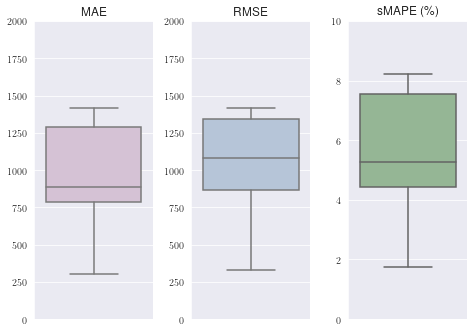

In [14]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 2000))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 2000))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 10))
plt.tight_layout()
plt.savefig('figures/supply_mlp_monthly_boxplot.pdf')

In [15]:
supply_mlp_month = [mae,rmse,smape]
%store supply_mlp_month

Stored 'supply_mlp_month' (list)
